# Movie Recommendation System - Wildan Aziz Hidayat

## Import Libraries

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

## Data Loading

In [59]:
movies = pd.read_csv('/home/wildanaziz/movie-recommendation-system/movie_dataset/movies.csv')
ratings = pd.read_csv('/home/wildanaziz/movie-recommendation-system/movie_dataset/ratings.csv')

print("Total samples and shape in movies dataset: ", movies.shape)
print("Total samples and shape in ratings dataset: ", ratings.shape)

Total samples and shape in movies dataset:  (10329, 3)
Total samples and shape in ratings dataset:  (105339, 4)


In [60]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB


In [61]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB


In [62]:
ratings.describe()

,userId,movieId,rating,timestamp
count,105339.000000,105339.000000,105339.000000,1.053390e+05
mean,364.924539,13381.312477,3.516850,1.130424e+09
std,197.486905,26170.456869,1.044872,1.802660e+08
min,1.000000,1.000000,0.500000,8.285650e+08
25%,192.000000,1073.000000,3.000000,9.711008e+08
50%,383.000000,2497.000000,3.500000,1.115154e+09
75%,557.000000,5991.000000,4.000000,1.275496e+09
max,668.000000,149532.000000,5.000000,1.452405e+09


In [63]:
print("lowest rating: ", ratings['rating'].min())
print("highest rating: ", ratings['rating'].max())

lowest rating:  0.5
highest rating:  5.0


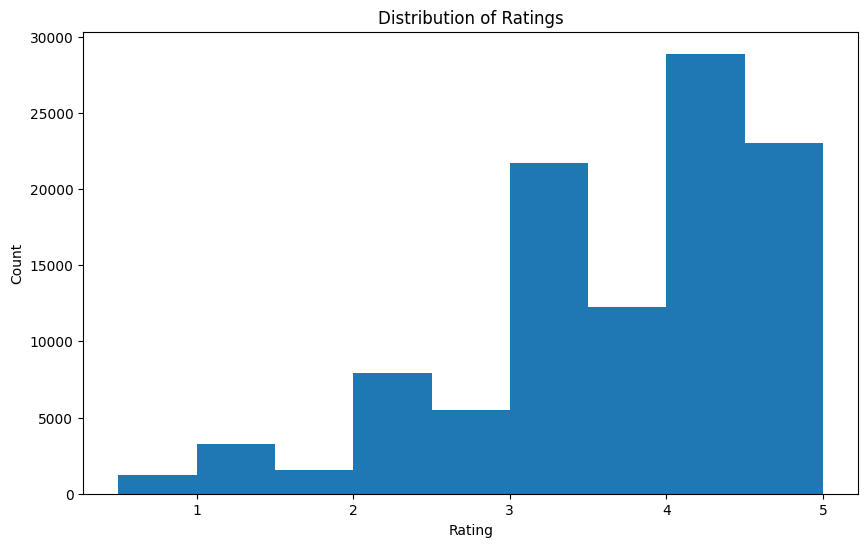

In [64]:
plt.figure(figsize=(10, 6))
bins=np.arange(0.5, 5.5, 0.5)
plt.hist(ratings['rating'], bins=bins)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()

Total user:  668
Total movie:  10325


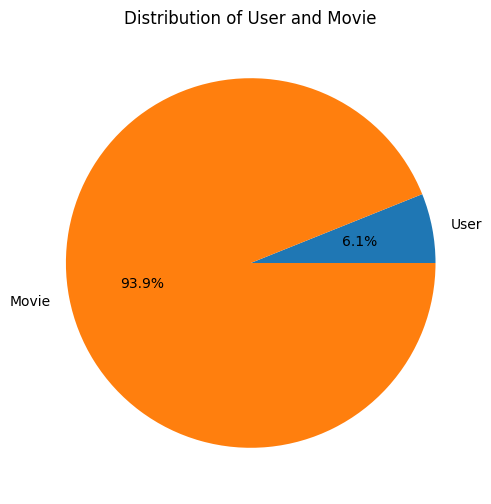

In [65]:
total_user = len(ratings['userId'].unique())
total_movie = len(ratings['movieId'].unique())
print("Total user: ", total_user)
print("Total movie: ", total_movie)

plt.figure(figsize=(10, 6))
plt.pie([total_user, total_movie], labels=['User', 'Movie'], autopct='%1.1f%%')
plt.title('Distribution of User and Movie')
plt.show()

## Data Preparation

In [66]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


#### Genre to List

In [67]:
movies['genres'] = movies['genres'].str.split('|')

In [68]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


### Checking Missing Value in Movies

In [69]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [71]:
genreList = [genre for genres in movies['genres'] for genre in genres]

uniqueGenre = pd.Series(genreList).unique()
print("Total genre: ", len(uniqueGenre))
print("Unique genre: ", uniqueGenre)

Total genre:  20
Unique genre:  ['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'IMAX' 'War'
 'Musical' 'Documentary' 'Western' 'Film-Noir' '(no genres listed)']


#### genreList to str

In [73]:
movies['genres_string'] = movies['genres'].apply(lambda x: ' '.join(g.replace(' ', '') for g in x))
movies.head()

,movieId,title,genres,genres_string
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",Adventure Children Fantasy
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",Comedy Romance
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",Comedy Drama Romance
4,5,Father of the Bride Part II (1995),[Comedy],Comedy


## Rating Prep

### Checking Missing Values

In [74]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

### Encode userId and movieId

In [75]:
user_ids = ratings['userId'].unique().tolist()
print("Total user_id: ", len(user_ids))

user_encoded = {user: i for i, user in enumerate(user_ids)}
print("encoded user_id: ", user_encoded)

user_decoded = {i: user for user, i in enumerate(user_ids)}
print("decoded user_id: ", user_decoded)

Total user_id:  668
encoded user_id:  {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 52, 54: 53, 55: 54, 56: 55, 57: 56, 58: 57, 59: 58, 60: 59, 61: 60, 62: 61, 63: 62, 64: 63, 65: 64, 66: 65, 67: 66, 68: 67, 69: 68, 70: 69, 71: 70, 72: 71, 73: 72, 74: 73, 75: 74, 76: 75, 77: 76, 78: 77, 79: 78, 80: 79, 81: 80, 82: 81, 83: 82, 84: 83, 85: 84, 86: 85, 87: 86, 88: 87, 89: 88, 90: 89, 91: 90, 92: 91, 93: 92, 94: 93, 95: 94, 96: 95, 97: 96, 98: 97, 99: 98, 100: 99, 101: 100, 102: 101, 103: 102, 104: 103, 105: 104, 106: 105, 107: 106, 108: 107, 109: 108, 110: 109, 111: 110, 112: 111, 113: 112, 114: 113, 115: 114, 116: 115, 117: 116, 118: 117,

In [76]:
movie_ids = ratings['movieId'].unique().tolist()
print("Total movie_id: ", len(movie_ids))

movie_encoded = {movie: i for i, movie in enumerate(movie_ids)}
print("encoded movie_id: ", movie_encoded)

movie_decoded = {i: movie for movie, i in enumerate(movie_ids)}
print("decoded movie_id: ", movie_decoded)

Total movie_id:  10325
encoded movie_id:  {16: 0, 24: 1, 32: 2, 47: 3, 50: 4, 110: 5, 150: 6, 161: 7, 165: 8, 204: 9, 223: 10, 256: 11, 260: 12, 261: 13, 277: 14, 296: 15, 318: 16, 349: 17, 356: 18, 377: 19, 380: 20, 457: 21, 480: 22, 527: 23, 589: 24, 590: 25, 592: 26, 593: 27, 597: 28, 608: 29, 648: 30, 719: 31, 724: 32, 736: 33, 780: 34, 858: 35, 912: 36, 968: 37, 1061: 38, 1089: 39, 1136: 40, 1196: 41, 1198: 42, 1210: 43, 1213: 44, 1220: 45, 1221: 46, 1222: 47, 1233: 48, 1243: 49, 1258: 50, 1265: 51, 1267: 52, 1270: 53, 1287: 54, 1580: 55, 1617: 56, 1721: 57, 1923: 58, 1961: 59, 2021: 60, 2028: 61, 2105: 62, 2161: 63, 2194: 64, 2396: 65, 2407: 66, 2455: 67, 2467: 68, 2502: 69, 2542: 70, 2571: 71, 2628: 72, 2716: 73, 2728: 74, 2762: 75, 2858: 76, 2947: 77, 2959: 78, 3256: 79, 3421: 80, 3578: 81, 4011: 82, 4027: 83, 4033: 84, 4085: 85, 4262: 86, 4306: 87, 4963: 88, 4993: 89, 4995: 90, 5349: 91, 5378: 92, 5418: 93, 5445: 94, 5952: 95, 6365: 96, 6711: 97, 6807: 98, 7153: 99, 8825: 100,

### Map into new columns

In [77]:
ratings['user_id'] = ratings['userId'].map(user_encoded)
ratings['movie_id'] = ratings['movieId'].map(movie_encoded)

### Splitting Data

In [79]:
ratings = ratings.sample(frac=1, random_state=42)
ratings

,userId,movieId,rating,timestamp,user_id,movie_id
41032,285,2605,3.0,974036328,284,1575
1938,24,897,4.0,963472695,23,1118
92480,607,4016,4.0,979339130,606,318
30160,219,3981,2.0,1011718777,218,2522
28079,203,546,2.0,955137146,202,407
...,...,...,...,...,...,...
54886,402,780,2.5,1172355892,401,34
76820,541,2334,4.0,1004508382,540,2489
103694,668,55288,2.5,1242489706,667,2733
860,11,377,3.0,850815719,10,19


In [115]:
ratings_fix = ratings[['userId', 'movieId', 'rating', 'user_id', 'movie_id']]
ratings_fix

,userId,movieId,rating,user_id,movie_id
41032,285,2605,3.0,284,1575
1938,24,897,4.0,23,1118
92480,607,4016,4.0,606,318
30160,219,3981,2.0,218,2522
28079,203,546,2.0,202,407
...,...,...,...,...,...
54886,402,780,2.5,401,34
76820,541,2334,4.0,540,2489
103694,668,55288,2.5,667,2733
860,11,377,3.0,10,19


In [116]:
X = ratings_fix[['user_id', 'movie_id']]

y = ratings_fix['rating'].apply(lambda x: (x - 0.5) / (5.0 - 0.5)).values

train_indices = int(ratings_fix.shape[0] * 0.8)
X_train, X_val, y_train, y_val = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("y_train shape: ", y_train.shape)
print("y_val shape: ", y_val.shape)
print("Training data: ", X)
print("Target data: ", y)

X_train shape:  (84271, 2)
X_val shape:  (21068, 2)
y_train shape:  (84271,)
y_val shape:  (21068,)
Training data:          user_id  movie_id
41032       284      1575
1938         23      1118
92480       606       318
30160       218      2522
28079       202       407
...         ...       ...
54886       401        34
76820       540      2489
103694      667      2733
860          10        19
15795       127      1983

[105339 rows x 2 columns]
Target data:  [0.55555556 0.77777778 0.77777778 ... 0.44444444 0.55555556 0.55555556]


## Content-Based Filtering

In [83]:
data_content_based = movies
data_content_based.sample(10)

,movieId,title,genres,genres_string
7211,49396,Tenacious D in The Pick of Destiny (2006),"[Adventure, Comedy, Musical]",Adventure Comedy Musical
2047,2560,Ravenous (1999),"[Horror, Thriller]",Horror Thriller
7876,62208,Sound of the Mountain (Thunder of the Mountain...,[Drama],Drama
821,1013,"Parent Trap, The (1961)","[Children, Comedy, Romance]",Children Comedy Romance
9681,102760,Down Terrace (2009),"[Comedy, Crime, Drama]",Comedy Crime Drama
629,748,"Arrival, The (1996)","[Action, Sci-Fi, Thriller]",Action Sci-Fi Thriller
6620,33495,Kicking & Screaming (2005),[Comedy],Comedy
566,650,Moll Flanders (1996),[Drama],Drama
869,1069,"Murder, My Sweet (1944)","[Crime, Film-Noir, Thriller]",Crime Film-Noir Thriller
7534,55721,Elite Squad (Tropa de Elite) (2007),"[Action, Crime, Drama, Thriller]",Action Crime Drama Thriller


### TF-IDF

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer()
tf_idf.fit(data_content_based['genres_string'])

tf_idf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'horror', 'imax',
       'musical', 'mystery', 'nogenreslisted', 'noir', 'romance', 'sci',
       'thriller', 'war', 'western'], dtype=object)

In [86]:
tf_idf_matrix = tf_idf.transform(data_content_based['genres_string'])

tf_idf_matrix.shape

(10329, 22)

In [87]:
pd.DataFrame(tf_idf_matrix.todense(), columns=tf_idf.get_feature_names_out(), index=data_content_based['title']).sample(10, axis=1).sample(5, axis=0)

,fi,horror,war,comedy,western,romance,drama,musical,sci,thriller
title,,,,,,,,,,
Cloudy with a Chance of Meatballs (2009),0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000
Red (2008),0.0,0.0,0.0,0.0,0.000000,0.0,0.550387,0.0,0.0,0.83491
"Davy Crockett, King of the Wild Frontier (1955)",0.0,0.0,0.0,0.0,0.832344,0.0,0.000000,0.0,0.0,0.00000
"Ghost of Frankenstein, The (1942)",0.0,1.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000
"Most Hated Family in America, The (2007)",0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000


### Cosine Similarity

In [88]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tf_idf_matrix, tf_idf_matrix)
cosine_sim

array([[1.        , 0.79977247, 0.1589222 , ..., 0.2638368 , 0.        ,
        0.        ],
       [0.79977247, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.1589222 , 0.        , 1.        , ..., 0.60235038, 0.        ,
        0.        ],
       ...,
       [0.2638368 , 0.        , 0.60235038, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

### cosine_sim DataFrame

In [90]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data_content_based['title'], columns=data_content_based['title'])
print(cosine_sim_df.shape)

cosine_sim_df.sample(10, axis=1).sample(5, axis=0)

(10329, 10329)


title,Guilty as Sin (1993),"Girl Who Kicked the Hornet's Nest, The (Luftslottet som sprängdes) (2009)","Leopard Man, The (1943)","American Haunting, An (2005)",Chain Reaction (1996),Fellini Satyricon (1969),Hereafter (2010),"Tetsuo, the Ironman (Tetsuo) (1988)",Attack the Block (2011),Stone (2010)
title,,,,,,,,,,
"Kingdom, The (2007)",0.530410,0.339414,0.385744,0.385744,0.698413,0.167196,0.167196,0.489422,0.310663,0.739518
Blackadder's Christmas Carol (1988),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.344642,0.000000
Pineapple Express (2008),0.452900,0.656832,0.000000,0.000000,0.343118,0.000000,0.000000,0.240444,0.437749,0.000000
I Confess (1953),0.598829,0.000000,0.435502,0.435502,0.516846,0.000000,0.000000,0.362186,0.000000,0.834910
Ink (2009),0.000000,0.206915,0.000000,0.000000,0.231229,0.502118,0.502118,0.670387,0.783547,0.000000


### Top-N Recommendations

In [93]:
def get_movie_recommendations(movie_name, similarity_data=cosine_sim_df, items=data_content_based[['title', 'genres']], k=5):
  

  index = similarity_data.loc[:, movie_name].to_numpy().argpartition(
      range(-1, -k, -1)
  )

  closest_similarity = similarity_data.columns[index[-1:-(k+2):-1]]

  closest_similarity = closest_similarity.drop(movie_name, errors='ignore')

  pd.set_option('display.max_columns', None)
  return pd.DataFrame(closest_similarity).merge(items).head(k)
     

In [98]:
movie_name_input = input("Enter movie name: ")
data_content_based[data_content_based['title'].str.contains(movie_name_input, case=False)]

,movieId,title,genres,genres_string
1923,2414,Young Sherlock Holmes (1985),"[Action, Adventure, Children, Fantasy, Mystery...",Action Adventure Children Fantasy Mystery Thri...
4827,6581,"Private Life of Sherlock Holmes, The (1970)","[Comedy, Drama, Mystery]",Comedy Drama Mystery
5030,6923,Sherlock Holmes and the Voice of Terror (1942),"[Crime, Mystery, War]",Crime Mystery War
5031,6924,Sherlock Holmes Faces Death (1943),"[Crime, Mystery]",Crime Mystery
5032,6925,Sherlock Holmes in Washington (1943),"[Crime, Mystery]",Crime Mystery
5637,8401,"Adventures of Sherlock Holmes, The (1939)","[Crime, Mystery, Thriller]",Crime Mystery Thriller
5786,8771,Sherlock Holmes: Terror by Night (1946),"[Crime, Mystery, Thriller]",Crime Mystery Thriller
5788,8773,Sherlock Holmes and the Secret Weapon (1942),"[Crime, Mystery, Thriller]",Crime Mystery Thriller
5789,8774,Sherlock Holmes: The Woman in Green (1945),[Mystery],Mystery
5915,25750,Sherlock Jr. (1924),"[Comedy, Fantasy, Romance]",Comedy Fantasy Romance


In [99]:
get_movie_recommendations("Sherlock Holmes (2010)", k=10)

,title,genres
0,"Andromeda Strain, The (1971)","[Mystery, Sci-Fi]"
1,Stalker (1979),"[Drama, Mystery, Sci-Fi]"
2,Solaris (Solyaris) (1972),"[Drama, Mystery, Sci-Fi]"
3,Sound of My Voice (2011),"[Drama, Mystery, Sci-Fi]"
4,Fire in the Sky (1993),"[Drama, Mystery, Sci-Fi]"
5,"Big Empty, The (2003)","[Comedy, Mystery, Sci-Fi]"
6,"Stepford Wives, The (1975)","[Mystery, Sci-Fi, Thriller]"
7,District 9 (2009),"[Mystery, Sci-Fi, Thriller]"
8,Seconds (1966),"[Mystery, Sci-Fi, Thriller]"
9,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"[Mystery, Sci-Fi, Thriller]"


### Collaborative Filtering

In [117]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, total_user, total_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.total_user = total_user
    self.total_movie = total_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        total_user,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(total_user, 1) # layer embedding user bias
    self.movie_embedding = layers.Embedding( # layer embeddings movies
        total_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(total_movie, 1) # layer embedding movies bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movie_vector = self.movie_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movie_bias = self.movie_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2) 
 
    x = dot_user_movie + user_bias + movie_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

In [119]:
model = RecommenderNet(total_user, total_movie, 100) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

In [120]:
# Definisikan callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_mean_absolute_error', # Metrik yang dipantau pada data validasi
    min_delta=0.001,                  # Perubahan minimum untuk dianggap perbaikan
    patience=7,                      # Jumlah epoch tanpa perbaikan sebelum berhenti
    restore_best_weights=True         # Mengembalikan bobot terbaik setelah berhenti
)

# Melatih model dengan callback EarlyStopping
models = model.fit(
    x=X_train,
    y=y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]        # Tambahkan callback di sini
)

Epoch 1/50
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 52s 19ms/step - loss: 0.6525 - mean_absolute_error: 0.2053 - val_loss: 0.6146 - val_mean_absolute_error: 0.1651
Epoch 2/50
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - loss: 0.6147 - mean_absolute_error: 0.1656 - val_loss: 0.6151 - val_mean_absolute_error: 0.1683
Epoch 3/50
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 49s 19ms/step - loss: 0.6165 - mean_absolute_error: 0.1675 - val_loss: 0.6155 - val_mean_absolute_error: 0.1670
Epoch 4/50
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 49s 19ms/step - loss: 0.6229 - mean_absolute_error: 0.1701 - val_loss: 0.6148 - val_mean_absolute_error: 0.1653
Epoch 5/50
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - loss: 0.6246 - mean_absolute_error: 0.1695 - val_loss: 0.6155 - val_mean_absolute_error: 0.1648
Epoch 6/50
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 66s 25ms/step - loss: 0.6252 - mean_absolute_error: 0.1712 - val_loss: 0.6153 - val_mean_absolute_error: 0.1651
Epoch 7/50
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 66s 25ms/step - loss: 0.6212 - mea

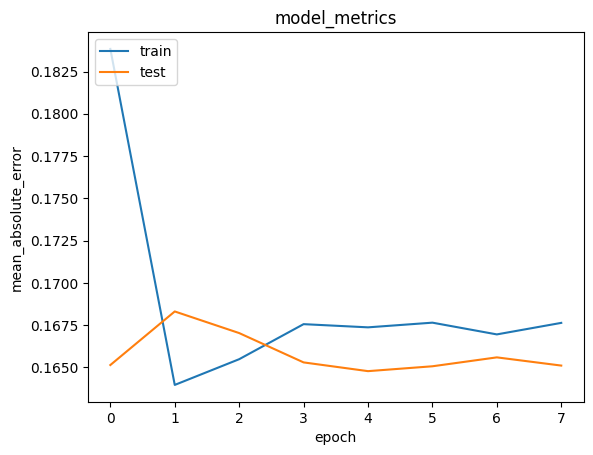

In [121]:
plt.plot(models.history['mean_absolute_error'])
plt.plot(models.history['val_mean_absolute_error'])
plt.title('model_metrics')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [126]:
movies_df = movies

# get sample user
user_id = ratings_fix.user_id.sample(1).iloc[0]
movie_watched_by_user = ratings_fix[ratings_fix.user_id == user_id]

movie_not_watched = movies_df[~movies_df['movieId'].isin(movie_watched_by_user.movieId.values)]['movieId']
movie_not_watched = list(
    set(movie_not_watched)
    .intersection(set(movie_encoded.keys()))
)

movie_not_watched = [[movie_encoded.get(x)] for x in movie_not_watched]
user_encoder = user_encoded.get(user_id)
user_movies_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)

In [129]:
ratings = model.predict(user_movies_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::1]
recommended_movies_ids = [
    movie_decoded.get(movie_not_watched[x][0]) for x in top_ratings_indices
]

print(f"Showing recommendations for user: {user_id}")
print("=" * 40)

print("Movies with high ratings from user")
print("-" * 40)

top_movies_user = (
    movie_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

anime_df_rows = movies_df[movies_df['movieId'].isin(top_movies_user)]
for row in anime_df_rows.itertuples():
  print(f"{row.title} : {', '.join(row.genres)}")

print('-' * 40)
print("Top 10 movies recommendations")
print('-' * 40)

recommended_movies = movies_df[movies_df['movieId'].isin(recommended_movies_ids)]
for row in recommended_movies.itertuples():
  print(f"{row.title} : {', '.join(row.genres)}")

321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Showing recommendations for user: 521
Movies with high ratings from user
----------------------------------------
True Lies (1994) : Action, Adventure, Comedy, Romance, Thriller
For Love or Money (1993) : Comedy, Romance
Much Ado About Nothing (1993) : Comedy, Romance
Sleepless in Seattle (1993) : Comedy, Drama, Romance
Mission: Impossible (1996) : Action, Adventure, Mystery, Thriller
----------------------------------------
Top 10 movies recommendations
----------------------------------------
Grumpier Old Men (1995) : Comedy, Romance
Turbo: A Power Rangers Movie (1997) : Action, Adventure, Children
Take the Money and Run (1969) : Comedy, Crime
Sixteen Candles (1984) : Comedy, Romance
Fast Food, Fast Women (2000) : Comedy, Romance
